In [285]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [286]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import logsumexp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import networkx as nx
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

In [287]:
# This is the sim_train_test function used later in the chapter 
# but it helps to instantiate it now
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def sim_train_test(N=20, k=1, rho=[0.15, -0.4], b_sigma=100):
    """
    Replicates R rethinking::sim_train_test function.
    
    Parameters:
    -----------
    N : int
        Sample size
    k : int
        Number of parameters (polynomial degree + intercept)
    rho : list
        Correlation parameters (default matches R)
    b_sigma : float
        Prior standard deviation for coefficients (not used in OLS, but kept for compatibility)
    
    Returns:
    --------
    dev_train, dev_test : tuple
        Training and test deviance (-2 * log-likelihood)
    """
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    

    Rho = np.eye(n_dim)
    for i in range(len(rho)):
        if i + 1 < n_dim:
            Rho[0, i + 1] = rho[i]
            Rho[i + 1, 0] = rho[i]  # Make symmetric
    

    X_train = np.random.multivariate_normal(mean=np.zeros(n_dim), cov=Rho, size=N)
    X_test = np.random.multivariate_normal(mean=np.zeros(n_dim), cov=Rho, size=N)
    
    y_train = X_train[:, 0]
    y_test = X_test[:, 0]
    
    mm_train = np.ones((N, 1))
    mm_test = np.ones((N, 1))
    
    if k > 1:
        mm_train = np.column_stack([mm_train, X_train[:, 1:k]])
        mm_test = np.column_stack([mm_test, X_test[:, 1:k]])
    
    model = LinearRegression(fit_intercept=False)
    model.fit(mm_train, y_train)
    

    mu_train = model.predict(mm_train)
    dev_train = -2 * np.sum(norm.logpdf(y_train, loc=mu_train, scale=1))
    
    mu_test = model.predict(mm_test)
    dev_test = -2 * np.sum(norm.logpdf(y_test, loc=mu_test, scale=1))
    
    return dev_train, dev_test

#### Code 7.1

In [288]:
sppnames = ['afarensis', 'africanus', 'habilis', 'boisei', 'rdolfensis', 'ergaster', 'sapiens']
brainvolcc = [438, 452, 612, 521 , 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame(dict(spp=sppnames, brain=brainvolcc, mass=masskg))

#### Code 7.2

In [ ]:
d['mass_std'] = scale.fit_transform(d[['mass']])
d['brain_std'] = d.brain / d.brain.max()

#### Code 7.3

In [304]:
with pm.Model() as m7_1:
    log_sigma = pm.Normal('log_sigma', 0, 1)
    a = pm.Normal('a', .5, 1)
    b = pm.Normal('b',0, 10)
    mu = pm.Deterministic('mu', a + b * d.mass_std)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = log_sigma, observed = d.brain_std)
    trace_m7_1 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


#### Code 7.4

In [291]:
m7_1_OLS = smf.ols('d.brain ~d.brain_std', data = d)
post = m7_1_OLS.fit()
display(post.params)


Intercept      1.705303e-13
d.brain_std    1.350000e+03
dtype: float64

#### Code 7.5

In [292]:
with m7_1:
    s = pm.sample_posterior_predictive(trace_m7_1).to_dataframe().drop(columns=['chain','draw'])
display(s.head(10))


r = s.mean(0).values - d.brain_std.values
resid_var = np.mean((r - np.mean(r))**2)
outcome_var = np.mean((d.brain_std - np.mean(d.brain_std))**2)
1 - resid_var/outcome_var

Sampling: [brain_std]


Output()

,"(brain_std[0], 0)","(brain_std[1], 1)","(brain_std[2], 2)","(brain_std[3], 3)","(brain_std[4], 4)","(brain_std[5], 5)","(brain_std[6], 6)"
0,0.376648,0.707056,0.404953,0.731079,0.316294,0.684451,0.511359
1,0.655438,0.305799,0.561190,0.064253,0.566542,0.544865,1.438811
2,0.481773,0.729202,-0.220324,0.045253,0.514039,0.493539,0.640081
3,0.637992,0.329057,0.130218,-0.172566,1.373625,0.571609,0.760400
4,0.796777,0.183222,0.528574,0.558282,0.747424,1.149329,0.812308
5,0.296187,-0.117009,0.804034,0.491515,1.365517,1.542216,0.935440
6,-0.840311,0.055013,-0.049349,0.126108,0.904971,1.864688,1.216636
7,0.233986,0.152607,0.008141,0.598594,1.082622,1.367085,1.015639
8,0.015647,0.077820,0.170559,0.116814,1.095987,2.254817,1.067463
9,1.312460,0.201053,0.805396,0.847327,0.204020,-0.255976,0.305714


0.4686982443478451

#### Code 7.6

In [293]:
def r2_is_bad(trace, model):
    with model:
        s = pm.sample_posterior_predictive(trace).to_dataframe().drop(columns=['chain','draw'])

    r = s.mean(0).values - d.brain_std.values
    r2 = 1 - np.mean((r - np.mean(r))**2)/np.mean((d.brain_std - np.mean(d.brain_std))**2)
    return r2


#### Code 7.7

In [294]:
with pm.Model() as m7_2: 
    log_sigma = pm.Normal('log_sigma',0,1)
    a = pm.Normal('a',.5,1)
    b = pm.Normal('b',0,10, shape = 2)
    mu = pm.Deterministic('mu', a +b[0]*d.mass_std + b[1]*d.mass_std**2)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = log_sigma, observed = d.brain_std)
    trace_m7_2 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})
    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 7.8

In [295]:
with pm.Model() as m7_3: 
    log_sigma = pm.Normal('log_sigma',0,1)
    a = pm.Normal('a',.5,1)
    b = pm.Normal('b',0,10, shape = 3)
    mu = pm.Deterministic('mu', a + b[0]*d.mass_std + 
                                    b[1]*d.mass_std**2 + 
                                    b[2]*d.mass_std**3)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = log_sigma, observed = d.brain_std)
    trace_m7_3 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

with pm.Model() as m7_4: 
    log_sigma = pm.Normal('log_sigma',0,1)
    a = pm.Normal('a',.5,1)
    b = pm.Normal('b',0,10, shape = 4)
    mu = pm.Deterministic('mu', a + b[0]*d.mass_std + 
                                    b[1]*d.mass_std**2 + 
                                    b[2]*d.mass_std**3 + 
                                    b[3]*d.mass_std**4)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = log_sigma, observed = d.brain_std)
    trace_m7_4 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

with pm.Model() as m7_5: 
    log_sigma = pm.Normal('log_sigma',0,1)
    a = pm.Normal('a',.5,1)
    b = pm.Normal('b',0,10, shape = 5)
    mu = pm.Deterministic('mu', a +b[0]*d.mass_std + 
                                    b[1]*d.mass_std**2 + 
                                    b[2]*d.mass_std**3 + 
                                    b[3]*d.mass_std**4 + 
                                    b[4]*d.mass_std**5)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = log_sigma, observed = d.brain_std)
    trace_m7_5 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 259 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 101 divergences after tuning. Increase `target_ac

#### Code 7.9

In [296]:
with pm.Model() as m7_6: 
    log_sigma = pm.Normal('log_sigma',0,1)
    a = pm.Normal('a',.5,1)
    b = pm.Normal('b',0,10, shape = 6)
    mu = pm.Deterministic('mu', a +b[0]*d.mass_std + 
                                    b[1]*d.mass_std**2 + 
                                    b[2]*d.mass_std**3 + 
                                    b[3]*d.mass_std**4 + 
                                    b[4]*d.mass_std**5 + 
                                    b[5]*d.mass_std**6)
    brain_std = pm.Normal('brain_std', mu = mu, sigma = .001, observed = d.brain_std)
    trace_m7_6 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 115 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Code 7.10

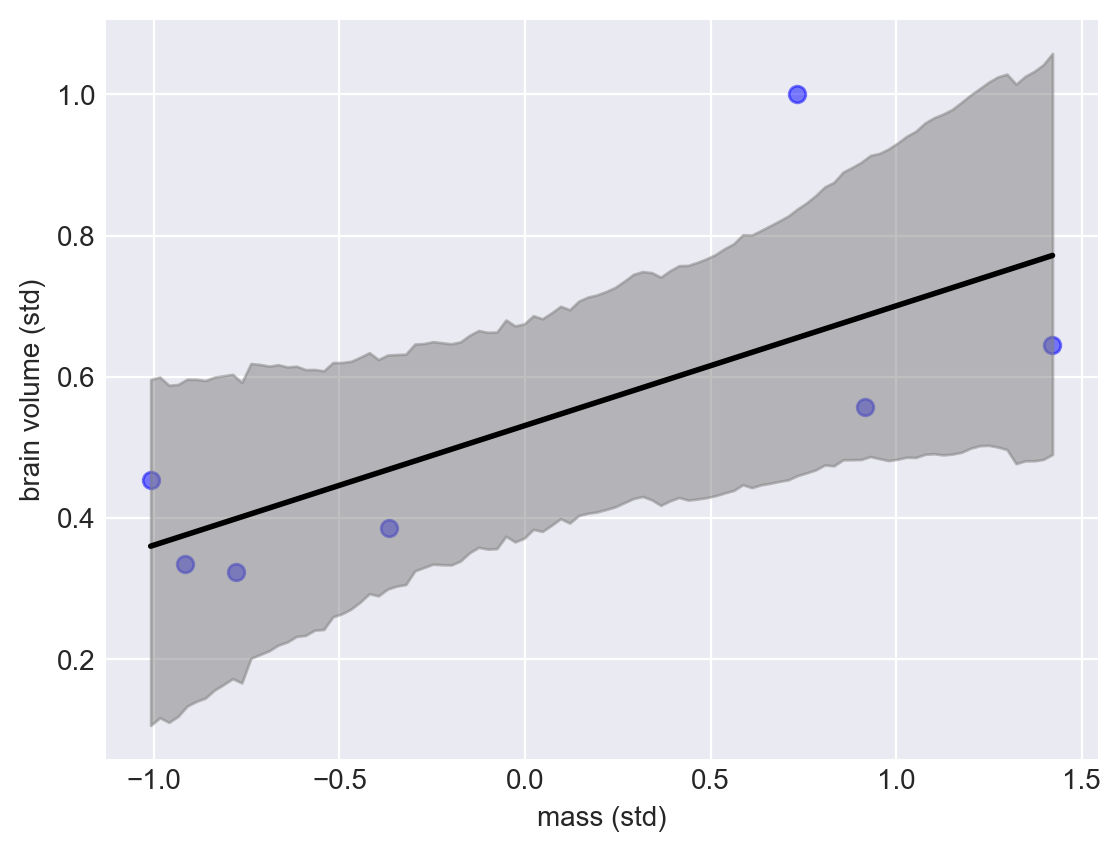

In [297]:
with m7_1:
    post = trace_m7_1.posterior.to_dataframe().reset_index().drop_duplicates(subset=['chain','draw'])

mass_seq = np.linspace(d.mass_std.min(), d.mass_std.max(), 100) 
post_a = post.a.values[:,None]
post_b = post.b.values[:,None]
mu_post = post_a + post_b * mass_seq[None, :]

mu = mu_post.mean(0) 
ci = az.hdi(mu_post, hdi_prob = .89)

plt.plot(mass_seq, mu, color = 'black', lw = 2)
plt.scatter(d.mass_std, d.brain_std, color = 'blue', alpha = .5)
plt.fill_between(mass_seq, ci[:,0], ci[:,1], color = 'grey', alpha = .5)
plt.xlabel('mass (std)')
plt.ylabel('brain volume (std)');


#### Code 7.11

In [298]:
for i in range(len(d)):
    d_minus_i = d.drop(index=i)

#### Code 7.12

In [299]:
p = [.3, .7]
-sum(p * np.log(p))

0.6108643020548935

#### Code 7.13

In [300]:
lppd = trace_m7_1.log_likelihood.to_dataframe().reset_index().drop_duplicates(subset=['chain','draw'])['brain_std'].values
lppd = np.mean(lppd)

print(lppd)

0.3464301084021119


#### Code 7.14

In [302]:
def compute_lppd_sum(model, variable_name='brain_std', draws=500, random_seed=1, cores=1):
    np.random.seed(random_seed)
    with model:
        trace = pm.sample(draws, cores=cores, idata_kwargs={'log_likelihood': True}, progressbar=False)
    log_prob = getattr(trace.log_likelihood, variable_name).values
    ns = log_prob.shape[0] * log_prob.shape[1]
    n = log_prob.shape[2]
    logprob = log_prob.reshape(ns, n)
    lppd = np.array([logsumexp(logprob[:, i]) - np.log(ns) for i in range(n)])
    return lppd.sum()

lppd = compute_lppd_sum(m7_2)
lppd

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0.8595501382381441

In [ ]:
models = [m7_1, m7_2, m7_3, m7_4, m7_5, m7_6]
lppds = [compute_lppd_sum(m) for m in models]
lppds


#TODO: this is notquite correct but also not consequential so I'm skipping it for now.




Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, a, b]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.
There were 4 divergences after tuning. Increase `target_accept` o

[1.5495695881783673,
 0.8209481104586072,
 0.9303228417863219,
 1.4003410101416875,
 2.2867340238989264,
 39.51250435821886]

#### Code 7.16

Simulating k=1...
Simulating k=2...
Simulating k=3...
Simulating k=4...
Simulating k=5...


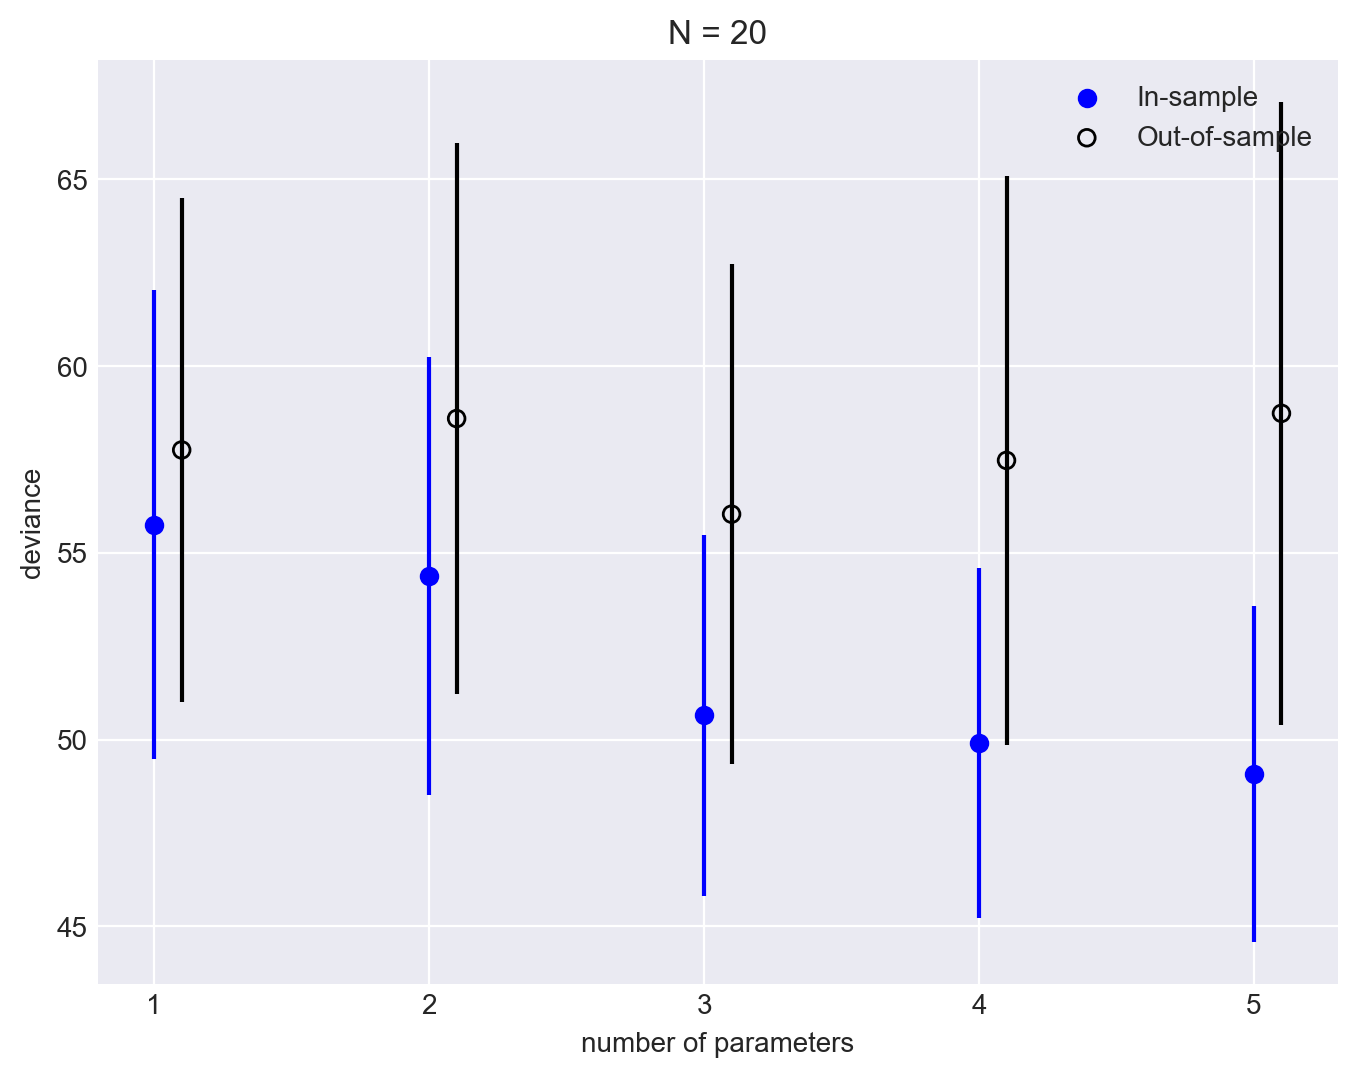

In [ ]:
N = 20
k_seq = range(1, 6)
n_reps = 10000

results = {}

for k in k_seq:
    print(f"Simulating k={k}...")
    # Run 10,000 times for each k
    r = np.array([sim_train_test(N=N, k=k) for _ in range(n_reps)])
    
    results[k] = {
        'mean_train': np.mean(r[:, 0]),
        'mean_test': np.mean(r[:, 1]),
        'sd_train': np.std(r[:, 0]),
        'sd_test': np.std(r[:, 1])
    }

df = pd.DataFrame(results).T


#### Code 7.17

_This is really not relevant here. The setting of cores is pretty machine dependent._

#### Code 7.18

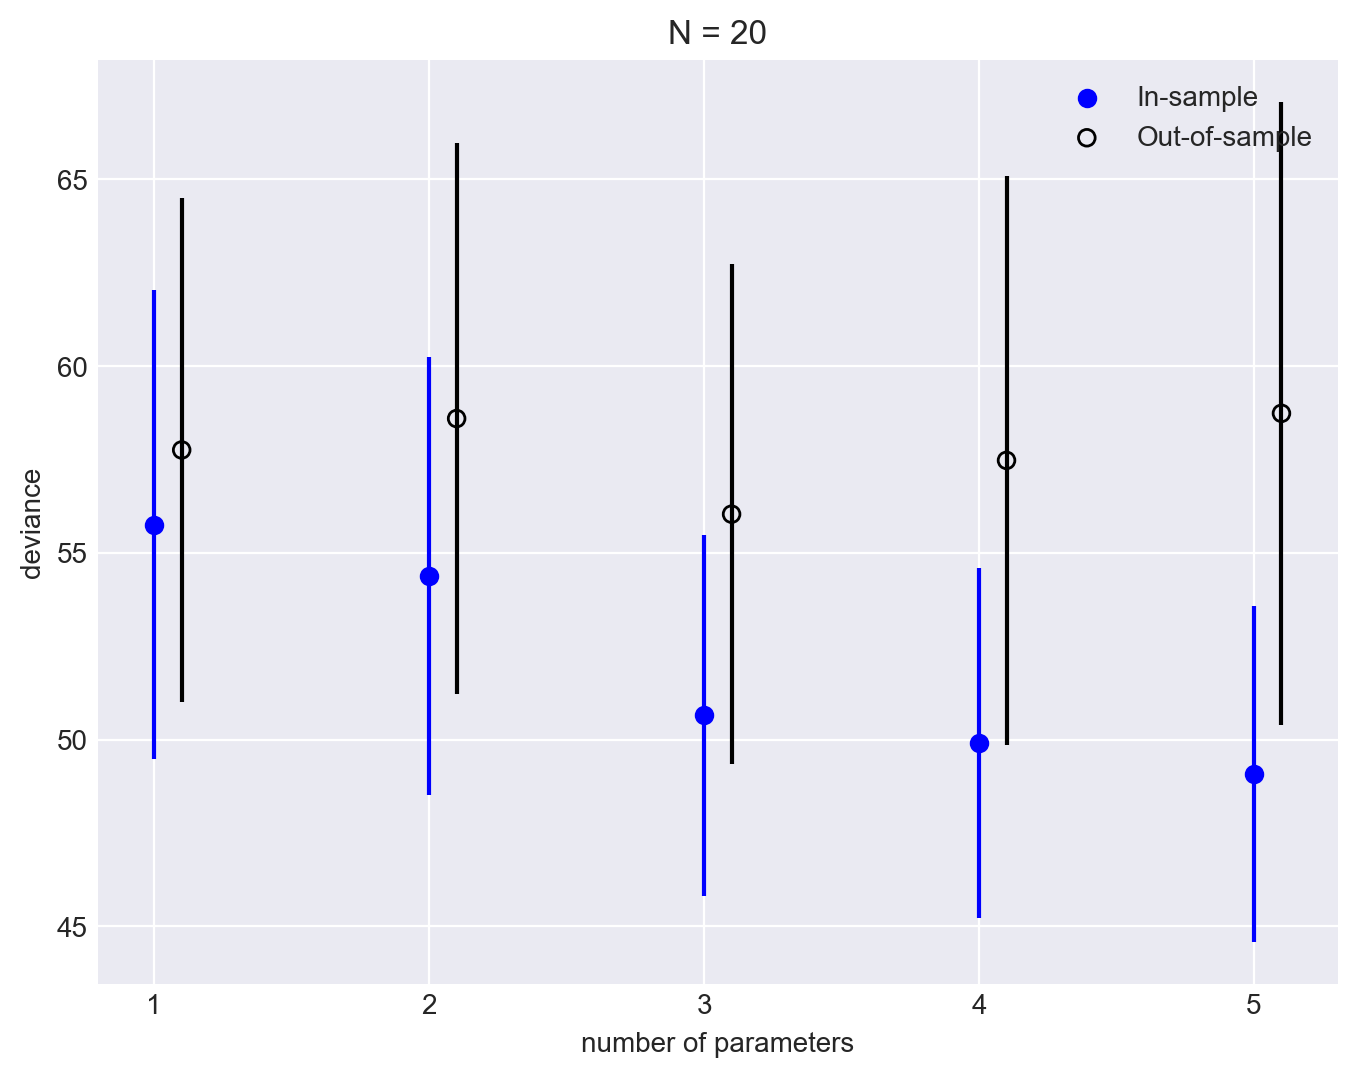

In [306]:

plt.figure(figsize=(8, 6))

plt.scatter(df.index, df['mean_train'], color='blue', label='In-sample')
plt.errorbar(df.index, df['mean_train'], yerr=df['sd_train'], fmt='none', ecolor='blue')

plt.scatter(df.index + 0.1, df['mean_test'], color='black', marker='o', facecolors='none', label='Out-of-sample')
plt.errorbar(df.index + 0.1, df['mean_test'], yerr=df['sd_test'], fmt='none', ecolor='black')

plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title(f"N = {N}")
plt.legend()
plt.show()

#### Code 7.19

In [355]:
cars = pd.read_csv('data/cars.csv', sep = ',', index_col = 0)
with pm.Model() as m: 
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 10) 
    mu = pm.Deterministic('mu', a + b * cars.speed)
    dist = pm.Normal('dist', mu = mu, sigma = sigma, observed = cars.dist)
    trace_m = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})
post = trace_m.posterior.to_dataframe().reset_index().drop_duplicates(subset=['chain','draw']).reset_index(drop=True)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 7.20

In [ ]:
n_samples = 1000
logprob = np.zeros((cars.shape[0],n_samples))

for s in range(n_samples):
    mu = post['a'][s] + post['b'][s] * cars['speed']
    p = stats.norm.logpdf(cars['dist'], loc=mu, scale=post['sigma'][s])
    logprob[:,s] = p


(50, 1000)


#### Code 7.21

In [364]:
n_cases = cars.shape[0]
lppd = np.array([logsumexp(logprob[i, :]) - np.log(n_samples) for i in range(n_cases)])
print(lppd.sum())

-206.57759753173815


#### Code 7.22

In [365]:
pWAIC = np.array([np.var(logprob[i, :]) for i in range(n_cases)])

print(pWAIC.sum())

4.04819082426471


#### Code 7.23

In [366]:
-2 * (lppd.sum() - pWAIC.sum())

421.2515767120057

#### Code 7.24

In [372]:
waic_vec = -2 * (lppd-pWAIC)
np.sqrt((np.var(waic_vec) * n_cases))

16.17376677989795

#### Code 7.25

In [383]:
trace_m6_6 = az.from_netcdf("data/model_traces/trace_m6_6.nc")
waic_m6_6 = pm.waic(trace_m6_6)
waic_m6_6

Computed from 2000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -210.57     6.04
p_waic        1.59        -

#### Code 7.26

In [393]:
trace_m6_7 = az.from_netcdf("data/model_traces/trace_m6_7.nc")
trace_m6_8 = az.from_netcdf("data/model_traces/trace_m6_8.nc")


comp = pm.compare({
    "m6_6": trace_m6_6,
    "m6_7": trace_m6_7,
    "m6_8": trace_m6_8,
    }, method="pseudo-BMA",
    ic = "waic", scale = 'deviance')

display(comp)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m6_7,0,333.367825,3.317233,0.000000,1.000000e+00,14.867481,0.000000,False,deviance
m6_8,1,417.163626,2.535252,83.795801,6.367559e-19,11.837898,13.430282,False,deviance
m6_6,2,421.134047,1.586254,87.766223,8.745948e-20,12.070928,13.487220,False,deviance


#### Code 7.27

In [532]:
waic_m6_7 = az.loo(trace_m6_7, pointwise=True, scale = 'deviance').values[6]
waic_m6_8 = az.loo(trace_m6_8, pointwise=True, scale = 'deviance').values[6]
diff_m6_7_m6_8 = (waic_m6_7 - waic_m6_8).values

print(np.sqrt(n * np.var(diff_m6_7_m6_8)))


13.43808211073874


#### Code 7.28

In [440]:
40.0 + np.array([-1,1]) * 10.4 * 2.6


array([12.96, 67.04])

#### Code 7.29

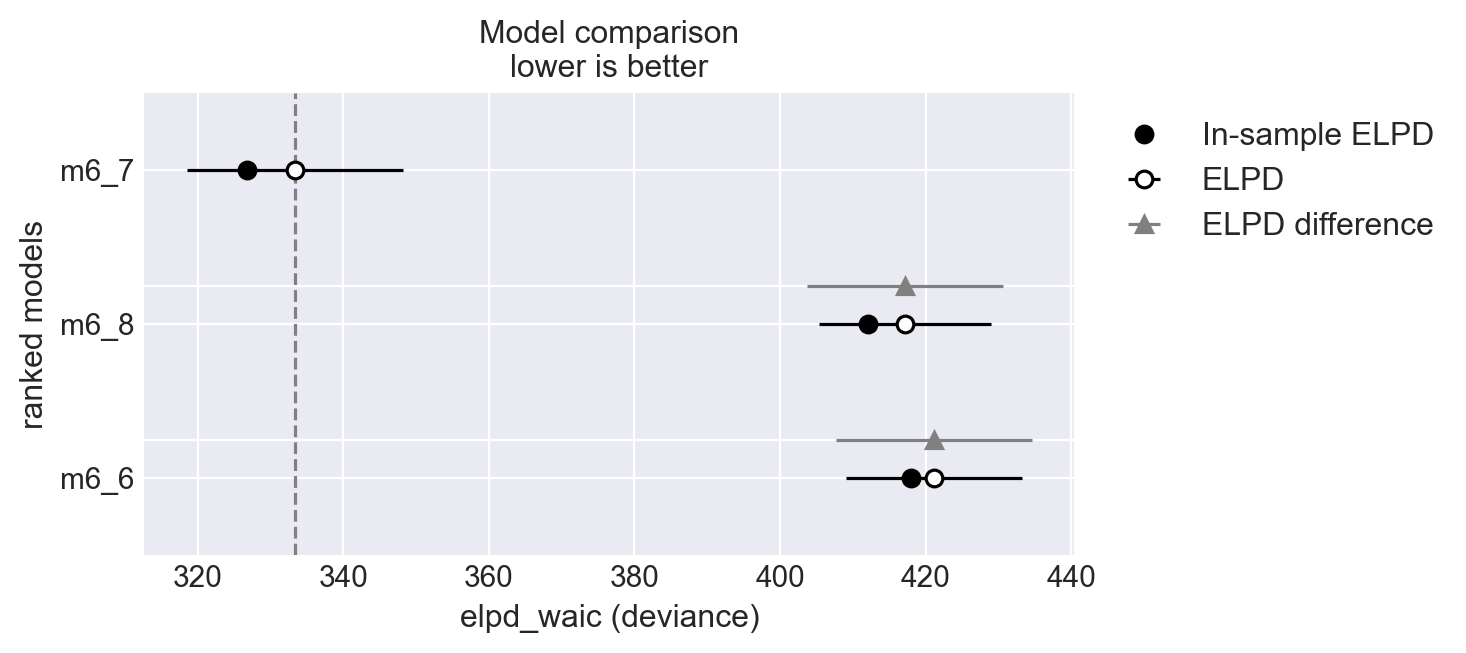

In [439]:
az.plot_compare(comp, insample_dev = True);

#### Code 7.30

In [457]:
waic_m6_6 = az.waic(trace_m6_6, pointwise=True, scale = 'deviance').values[6]
waic_m6_8 = az.waic(trace_m6_8, pointwise=True, scale = 'deviance').values[6]
n = az.waic(trace_m6_6, pointwise=True, scale = 'deviance').values[4]
diff_m6_6_m6_8 = (waic_m6_6 - waic_m6_8).values

print(np.sqrt(n * np.var(diff_m6_6_m6_8)))

5.06931876931278


#### Code 7.31

In [458]:
compare = pm.compare({
    "m6_6": trace_m6_6,
    "m6_7": trace_m6_7,
    "m6_8": trace_m6_8,
    }, method="pseudo-BMA",
    ic = "waic", scale = 'deviance')['se']

pairwise_diff = compare.values[:, None] - compare.values[None, :]
pairwise_diff_df = pd.DataFrame(pairwise_diff, index=compare.index, columns=compare.index)

pairwise_diff_df

,m6_7,m6_8,m6_6
m6_7,0.000000,3.029583,2.796553
m6_8,-3.029583,0.000000,-0.233029
m6_6,-2.796553,0.233029,0.000000


#### Code 7.32

In [463]:
d = pd.read_csv('data/WaffleDivorce.csv', sep = ';')
d['A'] = scale.fit_transform(d[['MedianAgeMarriage']])
d['D'] = scale.fit_transform(d[['Divorce']])
d['M'] = scale.fit_transform(d[['Marriage']])

with pm.Model() as m5_1:
    sigma = pm.Exponential('sigma', 1) 
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0,.5)
    mu = pm.Deterministic('mu', a + bA * d.A)
    D = pm.Normal('D', mu = mu, sigma = sigma, observed = d.D)
    trace_m5_1 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

with pm.Model() as m5_2:
    sigma = pm.Exponential('sigma', 1) 
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0,.5)
    mu = pm.Deterministic('mu', a + bM * d.M)
    D = pm.Normal('D', mu = mu, sigma = sigma, observed = d.D)
    trace_m5_2 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})
    
with pm.Model() as m5_3:
    sigma = pm.Exponential('sigma', 1) 
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0,.5)
    bM = pm.Normal('bM', 0,.5)
    mu = pm.Deterministic('mu', a + bA * d.A + bM * d.M)
    D = pm.Normal('D', mu = mu, sigma = sigma, observed = d.D)
    trace_m5_3 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bA]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bM]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bA, bM]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 7.33

In [467]:
np.random.seed(24071847)

pm.compare({
    "m5_1": trace_m5_1,
    "m5_2": trace_m5_2,
    "m5_3": trace_m5_3,
    }, method="pseudo-BMA",
    ic = "waic", scale = 'deviance')


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m5_1,0,126.548616,3.505147,0.000000,0.741347,12.544830,0.000000,True,deviance
m5_3,1,128.660837,4.738063,2.112221,0.257845,12.654947,0.634824,True,deviance
m5_2,2,140.192438,2.857424,13.643821,0.000808,9.725024,8.973343,True,deviance


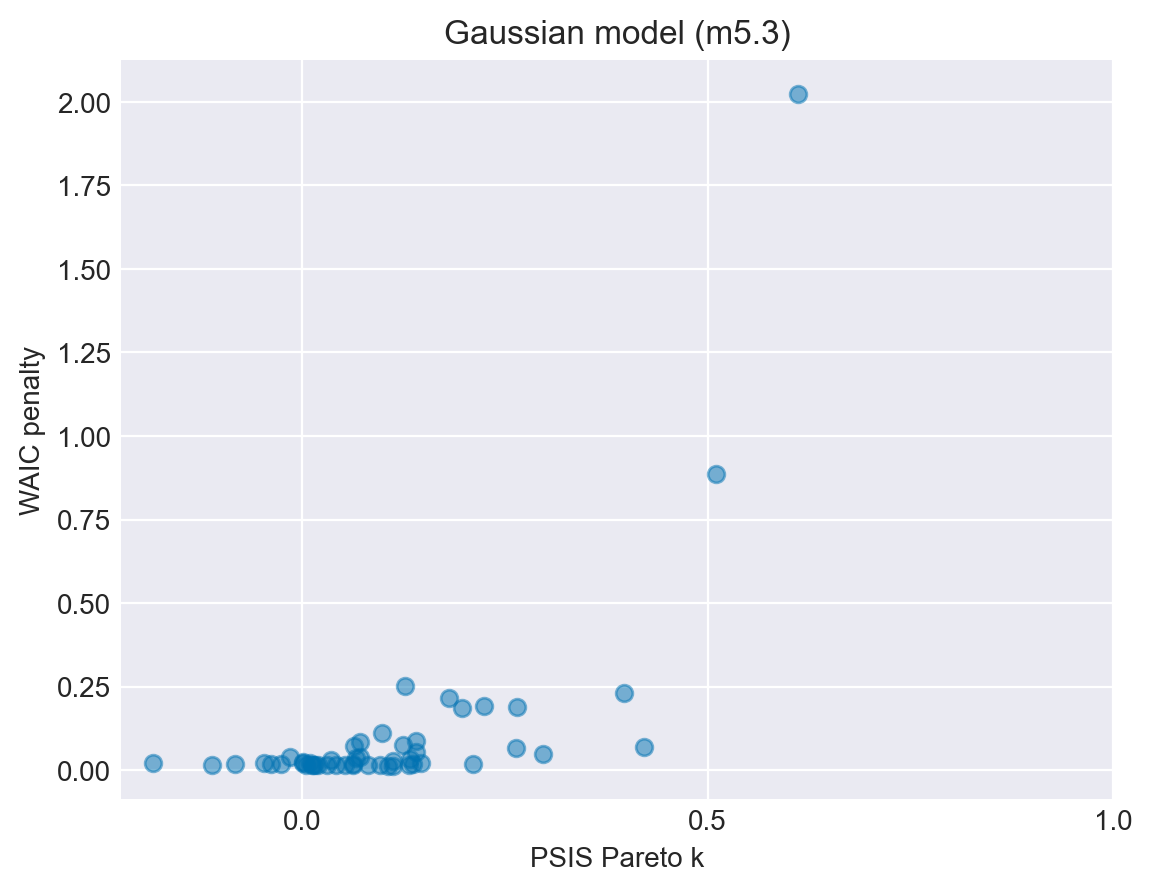

In [543]:
np.random.seed(24071847)

loo_m5_3 = az.loo(trace_m5_3, pointwise=True)
pareto_k = loo_m5_3.pareto_k.values


log_prob = trace_m5_3.log_likelihood.D.values
ns = log_prob.shape[0] * log_prob.shape[1]  
n = log_prob.shape[2] 
logprob = log_prob.reshape(ns, n)
p_waic_pointwise = np.array([np.var(logprob[:, i]) for i in range(n)])

# Plot
plt.scatter(pareto_k, p_waic_pointwise, alpha=0.5)
plt.xlabel('PSIS Pareto k')
plt.ylabel('WAIC penalty')
plt.title('Gaussian model (m5.3)')
plt.xticks([0.0, .5, 1])
plt.show()

#### Code 7.35

In [544]:
with pm.Model() as m5_3t:
    sigma =pm.Exponential('sigma',1)
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0,.5)
    bA = pm.Normal('bA', 0,.5)
    mu = pm.Deterministic('mu', a + bA * d.A + bM * d.M)
    D = pm.StudentT('D', nu = 2, mu = mu, sigma = sigma, observed = d.D)
    trace_m5_3t = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})




Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bM, bA]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
